# 1. Perceptron implementation
- Class definition is taken from the book
- The reason why we do not initialize the weights to 0 is explained in detail here, with the slightly confusing explanation from the book cited in the question (answer by Elias Strehle, link works June 2020): https://datascience.stackexchange.com/questions/26134/initialize-perceptron-weights-with-zero/27305#:~:text=Now%2C%20the%20reason%20we%20don,initialized%20to%20non%2Dzero%20values
- We use np.dot() instead of pure Python for calculating the dot product of 2 vectors because NumPy takes advantage of Vectorization and libraries that are written in more efficient low-level languages (C or Fortran)

In [5]:
import numpy as np

class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

# 2. Testing perceptron with the Iris dataset
## Loading the dataset

In [6]:
import os
import pandas as pd

df = pd.read_csv('data/iris.data', header=None, encoding='utf-8')
df.tail()

,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


## Selecting and visualizing the selected 2 (out of 4 available) features of the dataset

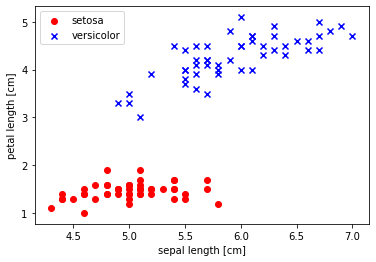

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# select setosa and versicolor
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)

# extract sepal length and petal length
X = df.iloc[0:100, [0, 2]].values

# plot data
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='x', label='versicolor')

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

# plt.savefig('images/02_06.png', dpi=300)
plt.show()

## Training the perceptron model

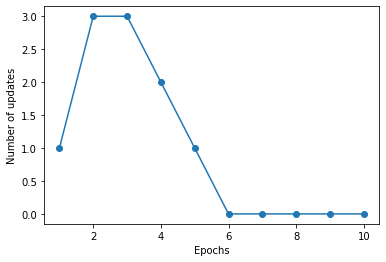

In [9]:
ppn = Perceptron(eta=0.1, n_iter=10)

ppn.fit(X, y)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')

# plt.savefig('images/02_07.png', dpi=300)
plt.show()

## Function for printing decision regions
- Code for the function is taken from the book, except for some modifications to make print out some intermediate structures with explanations of what they represent in the context of the given dataset
- The usage of np.meshgrid() and everything that it is used for later in the code might seem a bit confusing, at the moment of writing this my understanding is as follows:
   - We want to color the regions on different sides of the separation boundary in different colors. 
   - This can be done by creating a "mesh", which can be thought of as an overlap of 2 matrices, where each position represents one of the possible pairs of values: the first value from the generated array of values in-between the minimum and the maximum values of sepal length (what matters is the min and max values, the ones in-between are generated with a constant step, in this case 0.02) and the second value from a similar array, but for petal length.
   - Think of this as a way of going through all possible combinations of values that the 2 features of the dataset (sepal length, petal length) can potentially have and then we just put them on a grid, so that the combination (or a pair) that contains the shortest sepal and the shortest petal is in the top-left corner of the grid, and the combination that cointains the longest sepal and the longest petal is in the bottom-right corner of the grid. Now it is more or less intuitive to see how other combinations of values in-between these extremes will be distributed on the grid.
   - As the last step, which is more important, but does not need further explanations if you have a clear idea what the mesh represents, we apply our classifier to the entirety of the mesh as if every combination of sepal and petal lengths was a separate sample (this step includes a number of steps we need to do, such as flattening the mesh and transposing the input to the classifier) and on the output we
   get an array of -1s and 1s, which when reshaped back to the mesh form, represents which positions on the graph should be colored with one color (-1s) and which should be colored with another (1s).

In [30]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02, show_interm_structures=False):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))

    if (show_interm_structures):
        print("XX1 mesh grid:")
        print("- Every row is a range of values [min + 1, max + 1] for sepal length with a step of 0.02")
        print(xx1)
        print("\nXX2 mesh grid:")
        print("- Every column is a range of values [min + 1, max + 1] for petal length with a step of 0.02")
        print(xx2)

    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)

    if (show_interm_structures):
        print("\nInput to the classifier (remember, each row is a sample, each column is a feature):")
        print(np.array([xx1.ravel(), xx2.ravel()]).T)
        print("\nFlattened output from the classifier:")
        print(Z)

    Z = Z.reshape(xx1.shape)

    if (show_interm_structures):
        print("\nOutput from the classifier reshaped back to the mesh shape:")
        print(Z)

    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

XX1 mesh grid:
- Every row is a range of values [min, max] for sepal length with a step of 0.02
[[3.3  3.32 3.34 ... 7.94 7.96 7.98]
 [3.3  3.32 3.34 ... 7.94 7.96 7.98]
 [3.3  3.32 3.34 ... 7.94 7.96 7.98]
 ...
 [3.3  3.32 3.34 ... 7.94 7.96 7.98]
 [3.3  3.32 3.34 ... 7.94 7.96 7.98]
 [3.3  3.32 3.34 ... 7.94 7.96 7.98]]

XX2 mesh grid:
- Every column is a range of values [min, max] for petal length with a step of 0.02
[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 [0.04 0.04 0.04 ... 0.04 0.04 0.04]
 ...
 [6.04 6.04 6.04 ... 6.04 6.04 6.04]
 [6.06 6.06 6.06 ... 6.06 6.06 6.06]
 [6.08 6.08 6.08 ... 6.08 6.08 6.08]]

Input to the classifier (remember, each row is a sample, each column is a feature):
[[3.3  0.  ]
 [3.32 0.  ]
 [3.34 0.  ]
 ...
 [7.94 6.08]
 [7.96 6.08]
 [7.98 6.08]]

Flattened output from the classifier:
[-1 -1 -1 ...  1  1  1]

Output from the classifier reshaped back to the mesh shape:
[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 

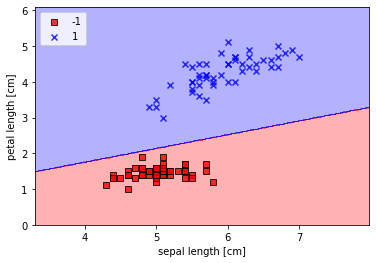

In [42]:
plot_decision_regions(X, y, classifier=ppn, show_interm_structures=True)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

# plt.savefig('images/02_08.png', dpi=300)
plt.show()